<a href="https://www.kaggle.com/code/zlatanshev/new-york-city-taxi-shevchenko?scriptVersionId=214898853" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Необходимо решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов, построить модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если разработать алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import category_encoders as ce

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
import optuna

from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

Прочитаем наш файл с исходными данными:

In [2]:
taxi_train = pd.read_csv("/kaggle/input/nyc-taxi-trip-duration/train.zip")
print('Train data shape: {}'.format(taxi_train.shape))
taxi_train.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

In [3]:
taxi_test = pd.read_csv("/kaggle/input/for-test-ds/Project5_test_data.csv")
print('Train data shape: {}'.format(taxi_test.shape))
taxi_test.head()

Train data shape: (625134, 9)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [4]:
taxi_train['sample'] = 1 # marking train
taxi_test['sample'] = 0 # marking test
taxi_test['trip_duration'] = 0 # editing target feature for test and fill it with 0

In [5]:
taxi_data = pd.concat([taxi_train,taxi_test], ignore_index=True).reset_index(drop=True)
display(taxi_data.head())
display(taxi_data.shape)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,sample
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1


(2083778, 12)

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

In [6]:
dupl_columns = list(taxi_data.columns)

mask = taxi_data.duplicated(subset=dupl_columns)
house_duplicates = taxi_data[mask]
print(f'Number of dublicates: {house_duplicates.shape[0]}')

Number of dublicates: 0


In [7]:
low_information_cols = [] 

#cycle through all columns
for col in taxi_data.columns:
    #the highest relative frequency in the feature
    top_freq = taxi_data[col].value_counts(normalize=True).max()
    #the proportion of unique values from the size of the feature
    nunique_ratio = taxi_data[col].nunique() / taxi_data[col].count()
    # compare the highest frequency with the threshold
    if top_freq > 0.7:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% identical values')
    # compare the unique frequency with the threshold
    if nunique_ratio > 0.7:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% unique values')
len(low_information_cols)

id: 100.0% unique values
pickup_datetime: 92.44% unique values
dropoff_datetime: 94.63% unique values
passenger_count: 70.88% identical values
store_and_fwd_flag: 99.45% identical values


5

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [8]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])
print(taxi_data['pickup_datetime'].min())
print(taxi_data['pickup_datetime'].max())

2016-01-01 00:00:17
2016-06-30 23:59:58


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [9]:
taxi_data.isnull().sum()

id                         0
vendor_id                  0
pickup_datetime            0
dropoff_datetime      625134
passenger_count            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
store_and_fwd_flag         0
trip_duration              0
sample                     0
dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [10]:
display(taxi_data.describe())
# 9 уникальных пассажиров

display(taxi_data.describe(include='object'))
display(taxi_data['vendor_id'].nunique()) # всего 2 уникальных таксопарка
display(taxi_data['trip_duration'].mean().__round__()) # среднее время поездки - 959 секунд
display(taxi_data['trip_duration'].median().__round__()) # медианное время поездки - 662 секунды
display(taxi_data['trip_duration'].max()) # максимальное время поездки - 3526282
display(taxi_data['trip_duration'].min()) #максимальное время поездки - 1

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,sample
count,2.083778e+06,2083778,2.083778e+06,2.083778e+06,2.083778e+06,2.083778e+06,2.083778e+06,2.083778e+06,2.083778e+06
mean,1.534930e+00,2016-04-01 11:09:23.931662848,1.663700e+00,-7.397352e+01,4.075092e+01,-7.397343e+01,4.075180e+01,6.716443e+02,6.999997e-01
min,1.000000e+00,2016-01-01 00:00:17,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,0.000000e+00,0.000000e+00
25%,1.000000e+00,2016-02-17 17:48:02,1.000000e+00,-7.399186e+01,4.073736e+01,-7.399133e+01,4.073592e+01,0.000000e+00,0.000000e+00
50%,2.000000e+00,2016-04-01 18:14:21,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397976e+01,4.075453e+01,4.320000e+02,1.000000e+00
75%,2.000000e+00,2016-05-15 06:05:20.500000,2.000000e+00,-7.396735e+01,4.076837e+01,-7.396301e+01,4.076982e+01,8.650000e+02,1.000000e+00
max,2.000000e+00,2016-06-30 23:59:58,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.885760e+01,3.526282e+06,1.000000e+00
std,4.987785e-01,NaN,1.313358e+00,7.165706e-02,3.200138e-02,7.122519e-02,3.587057e-02,4.403953e+03,4.582578e-01


,id,dropoff_datetime,store_and_fwd_flag
count,2083778,1458644,2083778
unique,2083778,1380377,2
top,id0621643,2016-02-19 19:25:04,N
freq,1,5,2072303


2

672

432

3526282

0

### Что интересного мы увидели? В данных присутствуют поездки, продолжительность которых составляет одну секунду, а также поездки, продолжительность которых больше 40 дней. Сразу приходит мысль, что это выбросы.

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [11]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df
taxi_data = add_datetime_features(taxi_data)
display(taxi_data.head())
taxi_data[taxi_data['pickup_day_of_week'] == 5].count() # в субботу было совершено 220868 поездок
taxi_data.groupby('pickup_date')['id'].count().mean().__round__() # в среднем за день совершается 8015 поездок

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,sample,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1,2016-03-14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1,2016-06-12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,2016-01-19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1,2016-04-06,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1,2016-03-26,13,5


11449

### Задание 2.5
Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 



In [12]:
holiday_data = pd.read_csv('/kaggle/input/added-ds/holiday_data.csv', sep=';')

def add_holiday_features(taxi_data, holiday_data):
    # Преобразование даты в holiday_data
    holiday_data['pickup_date'] = pd.to_datetime(holiday_data['date']).dt.date
    
    # Слияние данных с использованием left join
    merged = taxi_data.merge(holiday_data[['pickup_date', 'holiday']], on='pickup_date', how='left')
    
    # Заполнение пропусков нулями
    merged['holiday'].fillna(0, inplace=True)
    
    # Создание бинарного признака
    merged['pickup_holiday'] = merged['holiday'].apply(lambda x: 1 if x != 0 else 0)
    merged = merged.drop('holiday', axis=1)
    
    return merged

taxi_merged = add_holiday_features(taxi_data, holiday_data)

In [13]:
taxi_merged[taxi_merged['pickup_holiday'] == 1]['trip_duration'].median().__round__()
# средняя длительность поездки в праздничные дни составляет 585 секунд

387

In [14]:
taxi_merged.shape

(2083778, 16)

### Задание 2.6
Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [15]:
osrm_train = pd.read_csv('/kaggle/input/added-ds/osrm_data_train.csv')
osrm_test = pd.read_csv('/kaggle/input/for-test-ds/Project5_osrm_data_test.csv')
osrm_data = pd.concat([osrm_train, osrm_test], ignore_index=True).reset_index(drop=True)

In [16]:
def add_osrm_features(taxi_merged, osrm_data):
    taxi_df = taxi_merged.merge(osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], on='id', how='left')
    return taxi_df

taxi_df = add_osrm_features(taxi_merged, osrm_data)
taxi_df.head()

(taxi_df['trip_duration'].median() - taxi_df['total_travel_time'].median()).__round__()
# разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью 
# поездки, полученной из OSRM = 372
taxi_df.isnull().sum()

id                         0
vendor_id                  0
pickup_datetime            0
dropoff_datetime      625134
passenger_count            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
store_and_fwd_flag         0
trip_duration              0
sample                     0
pickup_date                0
pickup_hour                0
pickup_day_of_week         0
pickup_holiday             0
total_distance             1
total_travel_time          1
number_of_steps            1
dtype: int64

In [17]:
taxi_df.shape

(2083778, 19)

In [18]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.


In [19]:
def add_geographical_features(taxi_df):
    # Используем apply для вычисления расстояния и направления для каждой строки
    taxi_df['haversine_distance'] = taxi_df.apply(lambda row: get_haversine_distance(row['pickup_latitude'], row['pickup_longitude'],
                                                                                   row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    
    taxi_df['direction'] = taxi_df.apply(lambda row: get_angle_direction(row['pickup_latitude'], row['pickup_longitude'],
                                                                         row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    return taxi_df

In [20]:
taxi_df = add_geographical_features(taxi_df)

In [21]:
taxi_df['haversine_distance'].median().__round__(2)

2.09

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [22]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_df[['pickup_latitude', 'pickup_longitude']],
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(taxi_df, kmeans):
    coords = np.hstack((taxi_df[['pickup_latitude', 'pickup_longitude']],
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']]))
    taxi_df['geo_cluster'] = kmeans.predict(coords)
    
    return taxi_df

taxi_df = add_cluster_features(taxi_df, kmeans)
taxi_df
# Подсчитываем количество поездок в каждом кластере
cluster_counts = taxi_df['geo_cluster'].value_counts()

# Находим наименьший по размеру кластер
smallest_cluster_size = cluster_counts.min()

print(f'Количество поездок в наименьшем по размеру географическом кластере: {smallest_cluster_size}')

Количество поездок в наименьшем по размеру географическом кластере: 3


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [23]:
weather_data = pd.read_csv('/kaggle/input/added-ds/weather_data.csv')
def add_weather_features(taxi_df, weather_data):
    weather_data['time'] = pd.to_datetime(weather_data['time'])
    weather_data['date'] = weather_data['time'].dt.date
    weather_data['hour'] = weather_data['time'].dt.hour
    weather_columns = [
        'date', 'hour', 'temperature', 'visibility',
        'wind speed', 'precip', 'events'
    ]
    taxi_df = taxi_df.merge(
        weather_data[weather_columns], 
        left_on=['pickup_date', 'pickup_hour'], 
        right_on=['date', 'hour'],
        how='left'
    )
    taxi_df = taxi_df.drop(['date', 'hour'], axis=1)
    return taxi_df

taxi_df = add_weather_features(taxi_df, weather_data)
print(taxi_df['events'].value_counts())
print(round((taxi_df['visibility'].isnull().mean() * 100),2))

events
Rain    83371
Snow    18815
Fog         2
Name: count, dtype: int64
0.82


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [24]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,5,4.4,8.0,27.8,0.3,NaN
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,2,28.9,16.1,7.4,0.0,NaN
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,2,-6.7,16.1,24.1,0.0,NaN
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,2,7.2,16.1,25.9,0.0,NaN
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,5,9.4,16.1,9.3,0.0,NaN


In [25]:
weather_col = ['temperature', 'visibility', 'wind speed', 'precip']
def fill_null_weather_data(df, col_lst):
    for col in col_lst:
        df[col] = df[col].fillna(df.groupby('pickup_date')[col].transform('median'))
    return df

taxi_df = fill_null_weather_data(taxi_df, weather_col)

taxi_df['events'] = taxi_df['events'].fillna('None')

OSRM_col = ['total_distance', 'total_travel_time', 'number_of_steps']

In [26]:
for col in OSRM_col:
    taxi_df[col] = taxi_df[col].fillna(taxi_df[col].median())

In [27]:
taxi_df['temperature'].median().__round__(1)

11.1

In [28]:
taxi_df.shape

(2083778, 27)

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


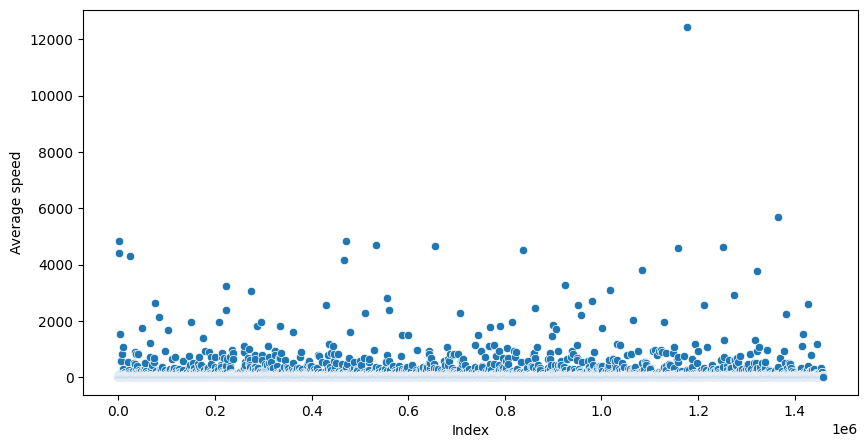

In [29]:
avg_speed = taxi_df['total_distance'] / taxi_df['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдем поездки, длительность которых превышает 24 часа. И удалите их из набора данных.


In [30]:
# ваш код здесь
taxi_df = taxi_df[~(taxi_df['trip_duration'] / 3600 > 24)]

In [31]:
taxi_df[taxi_df['sample'] == 1] = taxi_df[~(taxi_df['total_distance'] / taxi_df['trip_duration'] * 3.6 > 300)]

In [32]:
taxi_df[taxi_df['sample'] == 1] = taxi_df[~(taxi_df.passenger_count <= 0)]

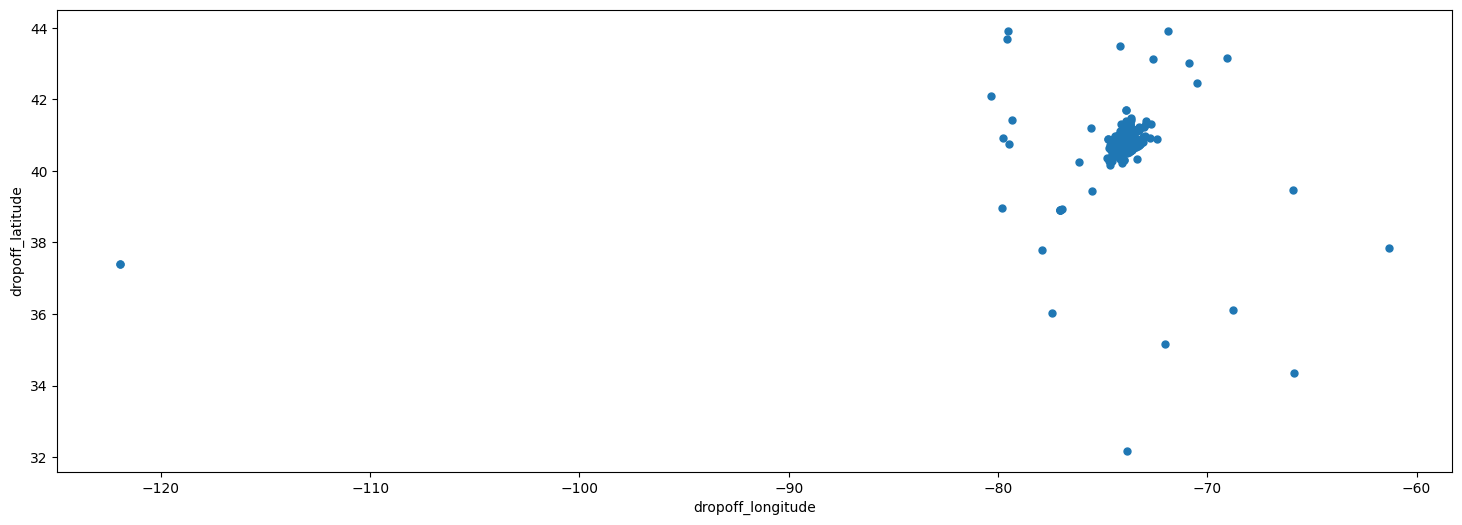

In [33]:
#Plot dropoff positions to visualize outliers
dropoff_longitude = list(taxi_df[taxi_df['sample'] == 1].dropoff_longitude)
dropoff_latitude = list(taxi_df[taxi_df['sample'] == 1].dropoff_latitude)
plt.subplots(figsize=(18,6))
plt.plot(dropoff_longitude, dropoff_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.show()

In [34]:
taxi_df[taxi_df['sample'] == 1] = taxi_df[~(taxi_df.dropoff_longitude < -90)]

In [35]:
taxi_df[taxi_df['sample'] == 1] = taxi_df[~(taxi_df.dropoff_latitude < 34)]

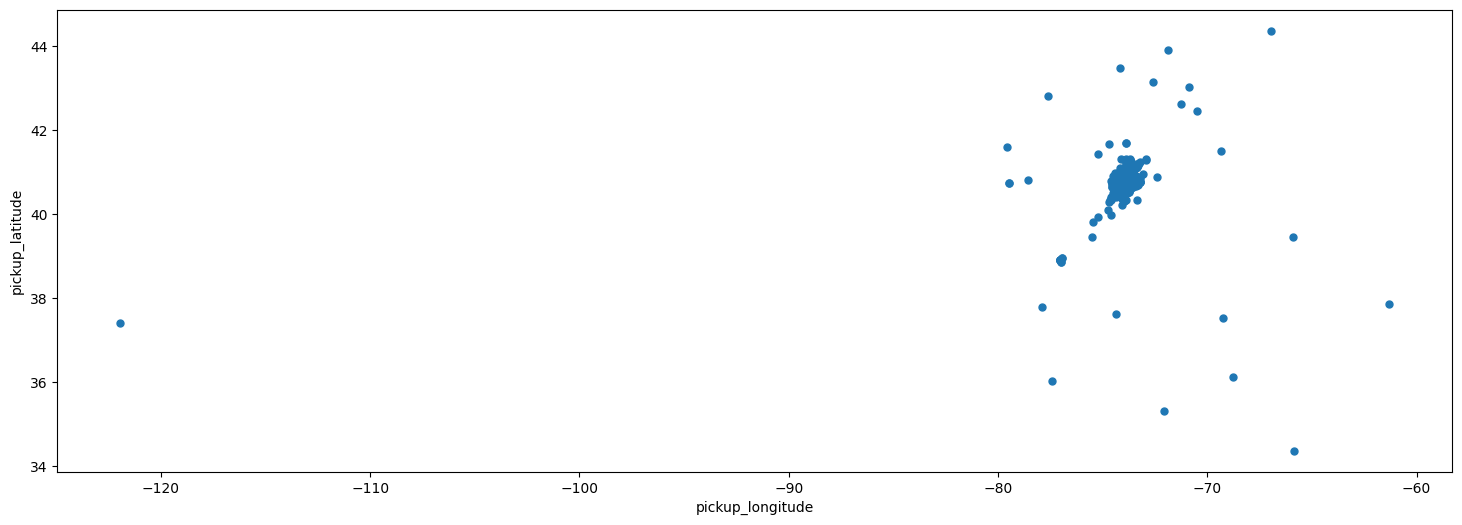

In [36]:
#Plot dropoff positions to visualize outliers
pickup_longitude = list(taxi_df.pickup_longitude)
pickup_latitude = list(taxi_df.pickup_latitude)
plt.subplots(figsize=(18,6))
plt.plot(pickup_longitude, pickup_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.show()

In [37]:
taxi_df[taxi_df['sample'] == 1] = taxi_df[~(taxi_df.pickup_longitude < -90)]

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. 

Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака


In [38]:
taxi_df['trip_duration_log'] = np.log1p(taxi_df['trip_duration'])

### Задание 3.1.
Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверим свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

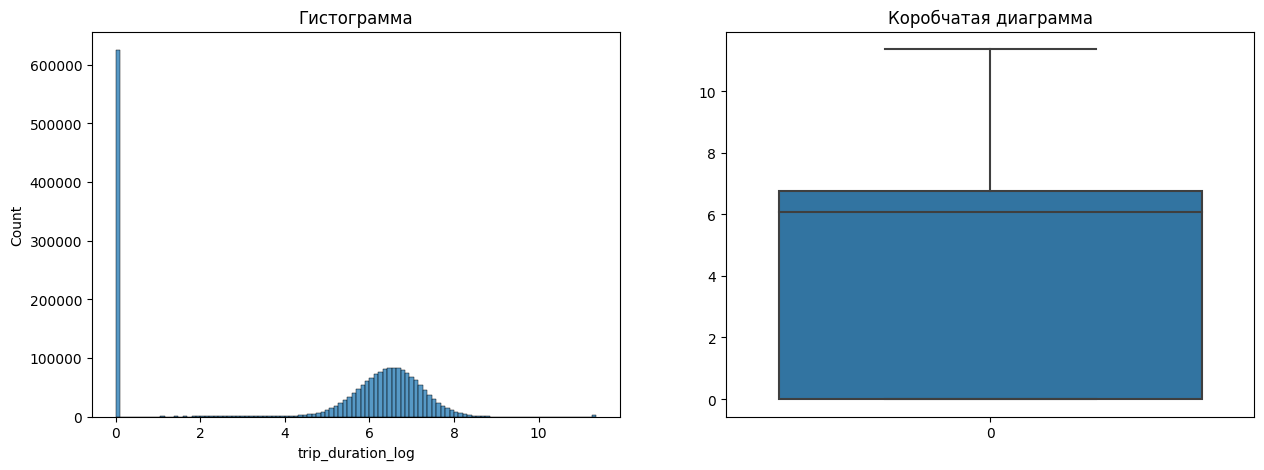

In [39]:
# ваш код здесь
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.histplot(taxi_df['trip_duration_log'], ax=axes[0])
axes[0].set_title('Гистограмма')
sns.boxplot(taxi_df['trip_duration_log'], ax=axes[1])
axes[1].set_title('Коробчатая диаграмма');

In [40]:
def dagostino_test(data):

    # Выполняем тест Д’Агостино
    stat, p_value = stats.normaltest(data)
    
    # Уровень значимости
    alpha = 0.05
    
    # Проверяем гипотезу
    if p_value < alpha:
        result = "Отвергаем нулевую гипотезу: данные не распределены нормально."
    else:
        result = "Не отвергаем нулевую гипотезу: данные распределены нормально."
    
    return {
        'statistic': stat,
        'p_value': p_value,
        'result': result
    }

# Пример использования функции
test_result = dagostino_test(taxi_df['trip_duration_log'])
print(test_result)


{'statistic': nan, 'p_value': nan, 'result': 'Не отвергаем нулевую гипотезу: данные распределены нормально.'}


### Задание 3.2.
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

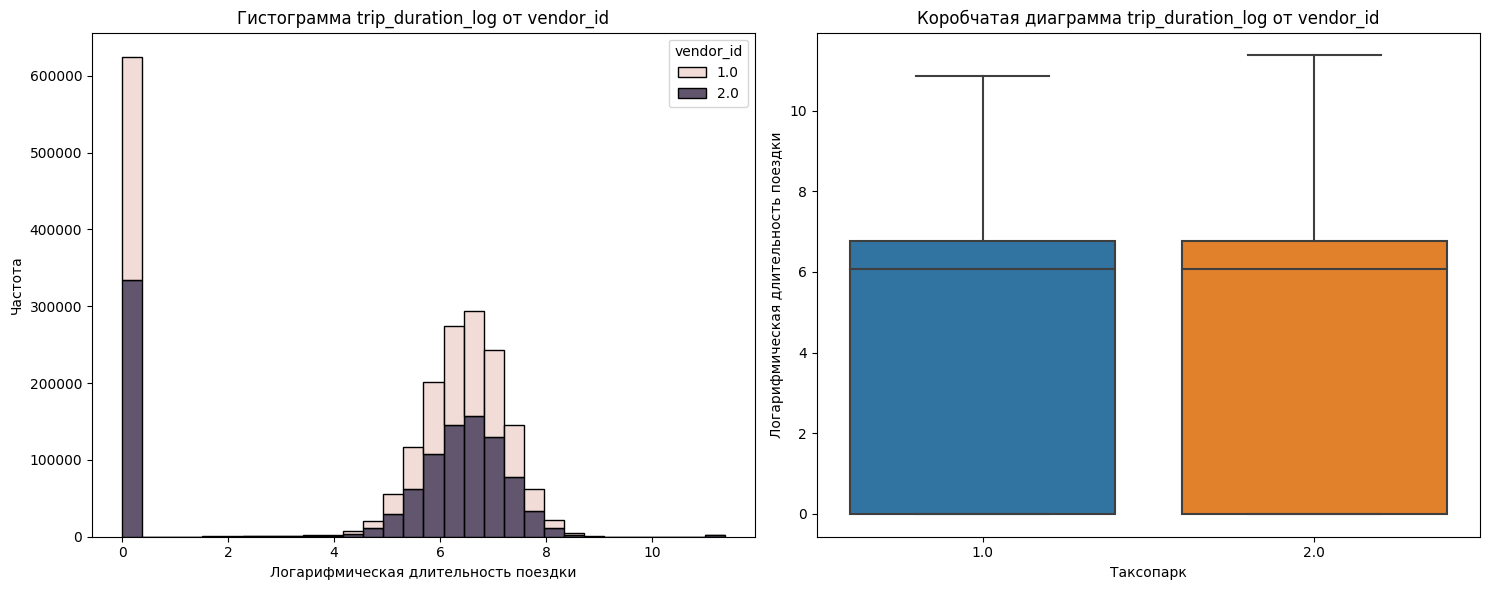

In [41]:
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Построение гистограммы
sns.histplot(data=taxi_df, x='trip_duration_log', hue='vendor_id', multiple='stack', ax=axes[0], bins=30)
axes[0].set_title('Гистограмма trip_duration_log от vendor_id')
axes[0].set_xlabel('Логарифмическая длительность поездки')
axes[0].set_ylabel('Частота')

# Построение коробчатой диаграммы
sns.boxplot(data=taxi_df, x='vendor_id', y='trip_duration_log', ax=axes[1])
axes[1].set_title('Коробчатая диаграмма trip_duration_log от vendor_id')
axes[1].set_xlabel('Таксопарк')
axes[1].set_ylabel('Логарифмическая длительность поездки')

# Отображение графиков
plt.tight_layout()
plt.show()

### Задание 3.3.
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

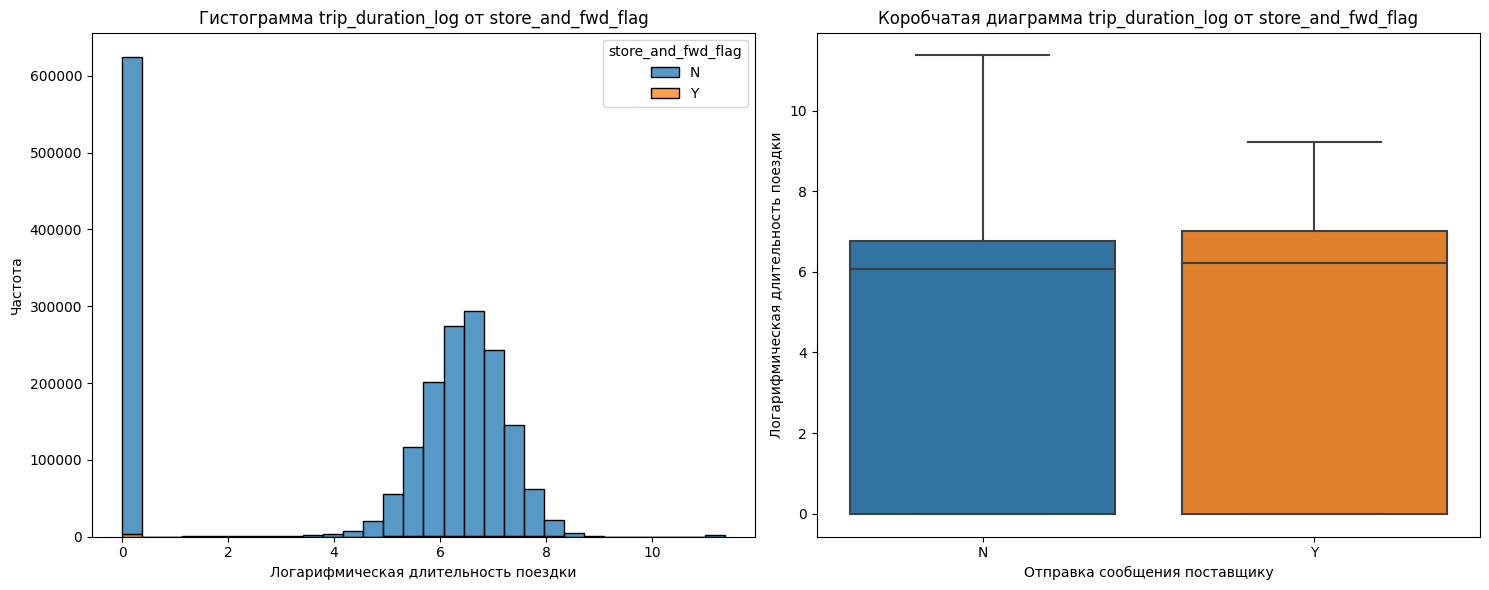

In [42]:
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Построение гистограммы
sns.histplot(data=taxi_df, x='trip_duration_log', hue='store_and_fwd_flag', multiple='stack', ax=axes[0], bins=30)
axes[0].set_title('Гистограмма trip_duration_log от store_and_fwd_flag')
axes[0].set_xlabel('Логарифмическая длительность поездки')
axes[0].set_ylabel('Частота')

# Построение коробчатой диаграммы
sns.boxplot(data=taxi_df, x='store_and_fwd_flag', y='trip_duration_log', ax=axes[1])
axes[1].set_title('Коробчатая диаграмма trip_duration_log от store_and_fwd_flag')
axes[1].set_xlabel('Отправка сообщения поставщику')
axes[1].set_ylabel('Логарифмическая длительность поездки')

# Отображение графиков
plt.tight_layout()
plt.show()

### Задание 3.4.
Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

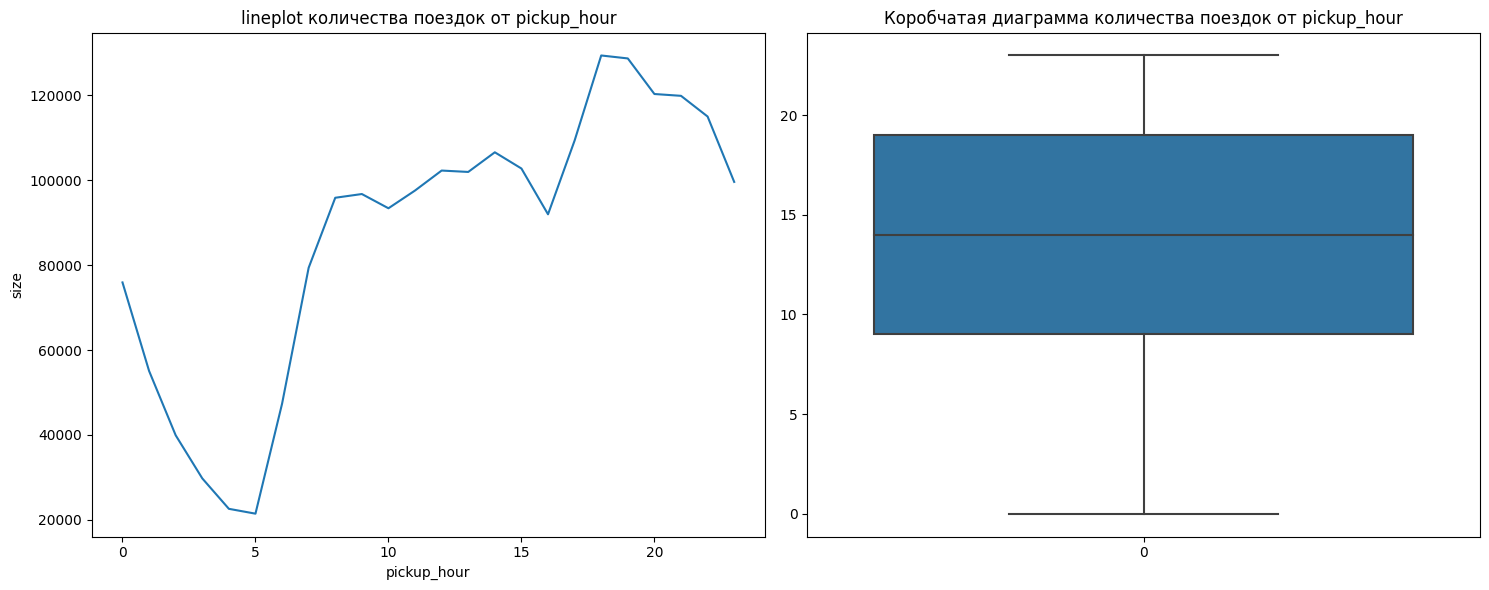

In [43]:
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

trip_counts = taxi_df.groupby('pickup_hour', as_index=False).size()
trip_counts
# Построение гистограммы
sns.lineplot(data=trip_counts, x='pickup_hour', y= 'size', ax=axes[0])
axes[0].set_title('lineplot количества поездок от pickup_hour')

# Построение коробчатой диаграммы
sns.boxplot(data=taxi_df['pickup_hour'], ax=axes[1])
axes[1].set_title('Коробчатая диаграмма количества поездок от pickup_hour')

# Отображение графиков
plt.tight_layout()
plt.show()

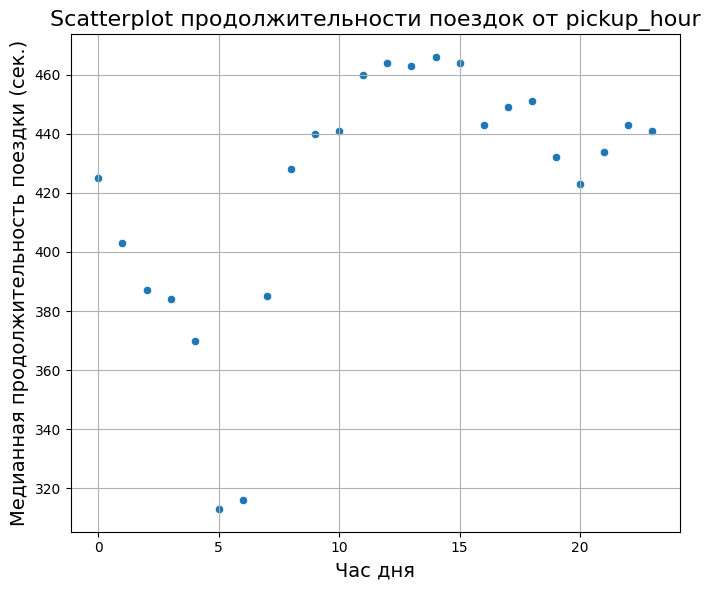

In [44]:
grouped = taxi_df.groupby('pickup_hour', as_index=False)['trip_duration'].median()
grouped
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# Построение scatterplot
sns.scatterplot(data=grouped, x='pickup_hour', y='trip_duration', ax=axes)

# Настройка заголовка и меток
axes.set_title('Scatterplot продолжительности поездок от pickup_hour', fontsize=16)
axes.set_xlabel('Час дня', fontsize=14)
axes.set_ylabel('Медианная продолжительность поездки (сек.)', fontsize=14)

# Добавление сетки для лучшей читаемости
axes.grid(True)

# Отображение графика
plt.tight_layout()
plt.show()


### Задание 3.5.
Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.


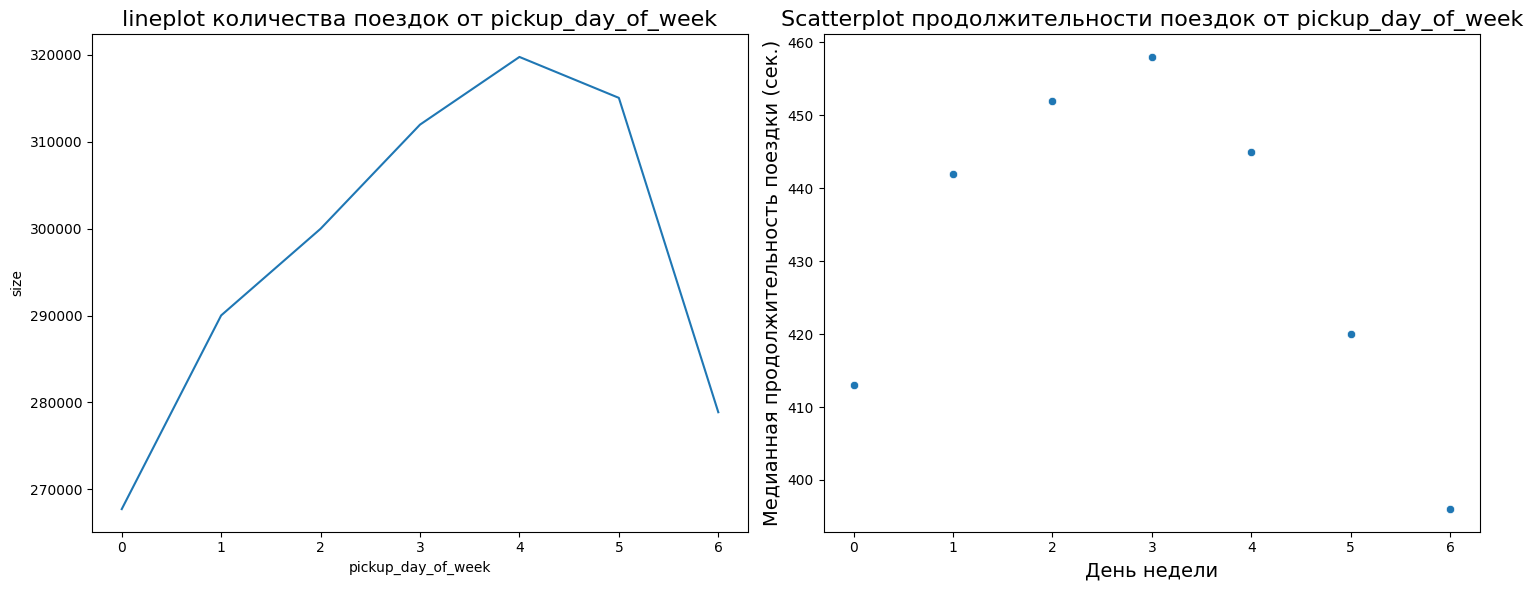

In [45]:
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

trip_counts_week = taxi_df.groupby('pickup_day_of_week', as_index=False).size()
trip_counts_week
# Построение Диаграммы
sns.lineplot(data=trip_counts_week, x='pickup_day_of_week', y= 'size', ax=axes[0])
axes[0].set_title('lineplot количества поездок от pickup_day_of_week', fontsize=16)

grouped_week = taxi_df.groupby('pickup_day_of_week', as_index=False)['trip_duration'].median()
grouped_week

# Построение scatterplot
sns.scatterplot(data=grouped_week, x='pickup_day_of_week', y='trip_duration', ax=axes[1])

# Настройка заголовка и меток
axes[1].set_title('Scatterplot продолжительности поездок от pickup_day_of_week', fontsize=16)
axes[1].set_xlabel('День недели', fontsize=14)
axes[1].set_ylabel('Медианная продолжительность поездки (сек.)', fontsize=14)

# Отображение графика
plt.tight_layout()
plt.show()

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты

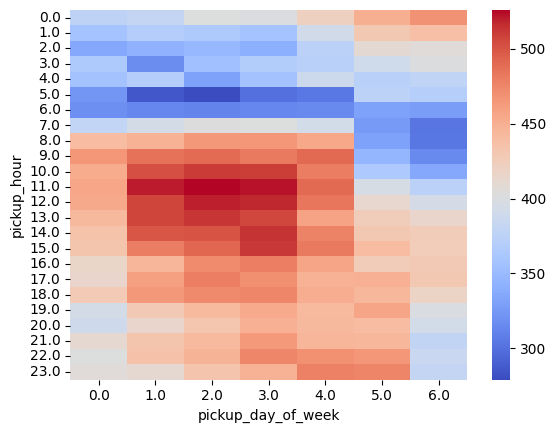

In [46]:
# ваш код здесь
pivot_data = pd.pivot_table(taxi_df, values='trip_duration', columns='pickup_day_of_week', index='pickup_hour', aggfunc='median')
pivot_data
sns.heatmap(pivot_data, cmap='coolwarm');

### Задание 3.7.
Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложим широту (longitude), а по оси ординат - долготу (latitude). 
Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [47]:
# # Задаем границы Нью-Йорка
# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85)

# # Фильтруем данные по границам
# pickup_data = taxi_df[(taxi_df['pickup_longitude'].between(*city_long_border)) &
#                       (taxi_df['pickup_latitude'].between(*city_lat_border))]

# dropoff_data = taxi_df[(taxi_df['dropoff_longitude'].between(*city_long_border)) &
#                         (taxi_df['dropoff_latitude'].between(*city_lat_border))]

# # Создание первой диаграммы рассеяния для точек начала поездок
# fig1 = px.scatter(
#     pickup_data,
#     x='pickup_longitude',
#     y='pickup_latitude',
#     color='geo_cluster',  # Раскраска по географическим кластерам
#     title='Географическое расположение точек начала поездок',
#     labels={'pickup_longitude': 'Долгота', 'pickup_latitude': 'Широта'},
#     size_max=5  # Уменьшаем размер точек для наглядности
# )

# # Создание второй диаграммы рассеяния для точек завершения поездок
# fig2 = px.scatter(
#     dropoff_data,
#     x='dropoff_longitude',
#     y='dropoff_latitude',
#     color='geo_cluster',  # Раскраска по географическим кластерам
#     title='Географическое расположение точек завершения поездок',
#     labels={'dropoff_longitude': 'Долгота', 'dropoff_latitude': 'Широта'},
#     size_max=5  # Уменьшаем размер точек для наглядности
# )

# # Отображение графиков
# fig1.show()
# fig2.show()


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [48]:
print('Shape of data: {}'.format(taxi_df.shape))
print('Columns: {}'.format(taxi_df.columns))

Shape of data: (2083774, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'sample', 'pickup_date', 'pickup_hour',
       'pickup_day_of_week', 'pickup_holiday', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'direction', 'geo_cluster', 'temperature', 'visibility', 'wind speed',
       'precip', 'events', 'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [49]:
taxi_data = taxi_df.copy()
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2.0,2016-03-14 17:24:55,2016-03-14 17:32:30,1.0,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,5.0,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1.0,2016-06-12 00:43:35,2016-06-12 00:54:38,1.0,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,2.0,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2.0,2016-01-19 11:35:24,2016-01-19 12:10:48,1.0,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,2.0,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2.0,2016-04-06 19:32:31,2016-04-06 19:39:40,1.0,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,2.0,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2.0,2016-03-26 13:30:55,2016-03-26 13:38:10,1.0,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,5.0,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 


In [50]:
# ваш код здесь
taxi_data.drop(['id', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1, inplace=True)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [51]:
drop_columns = ['pickup_datetime', 'pickup_date']
taxi_data = taxi_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(taxi_data.shape))

Shape of data:  (2083774, 23)


### Задание 4.2.

Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.



In [52]:
# ваш код здесь
taxi_data['vendor_id'] = taxi_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

In [53]:
print(taxi_data.nunique()[taxi_data.nunique() < 20])


vendor_id              2
passenger_count       10
sample                 2
pickup_day_of_week     7
pickup_holiday         2
geo_cluster           10
visibility            17
events                 4
dtype: int64


In [54]:
# Выбираем нужные столбцы для кодирования
columns_to_encode_dummies = ['passenger_count', 'pickup_day_of_week', 'geo_cluster', 'events']
cat_features_to_preproc_binary = ['visibility']

# Объявляем кодировщик
bin_encoder = ce.BinaryEncoder(cols=cat_features_to_preproc_binary) 
type_bin = bin_encoder.fit_transform(taxi_data[cat_features_to_preproc_binary])
taxi_data = pd.concat([taxi_data, type_bin], axis=1)

taxi_data = pd.get_dummies(taxi_data, columns=columns_to_encode_dummies, dtype='int64')

In [55]:
taxi_data = taxi_data.drop(['visibility'], axis=1)
taxi_data

,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,sample,pickup_hour,pickup_holiday,total_distance,...,geo_cluster_4.0,geo_cluster_5.0,geo_cluster_6.0,geo_cluster_7.0,geo_cluster_8.0,geo_cluster_9.0,events_Fog,events_None,events_Rain,events_Snow
0,1,-73.982155,40.767937,-73.964630,40.765602,455.0,1.0,17.0,0.0,2009.1,...,0,1,0,0,0,0,0,1,0,0
1,0,-73.980415,40.738564,-73.999481,40.731152,663.0,1.0,0.0,0.0,2513.2,...,0,0,0,0,0,0,0,1,0,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124.0,1.0,11.0,0.0,11060.8,...,0,0,0,0,0,0,0,1,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429.0,1.0,19.0,0.0,1779.4,...,0,0,0,0,0,0,0,1,0,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435.0,1.0,13.0,0.0,1614.9,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083773,0,-74.003464,40.725105,-74.001251,40.733643,0.0,0.0,0.0,1.0,1166.3,...,0,0,0,0,0,0,0,1,0,0
2083774,0,-74.006363,40.743782,-73.953407,40.782467,0.0,0.0,0.0,1.0,9572.1,...,1,0,0,0,0,0,0,1,0,0
2083775,0,-73.972267,40.759865,-73.876602,40.748665,0.0,0.0,0.0,1.0,9492.3,...,0,0,0,0,0,0,0,1,0,0
2083776,0,-73.976501,40.733562,-73.854263,40.891788,0.0,0.0,0.0,1.0,23770.1,...,0,0,0,0,0,0,0,1,0,0


In [56]:
new_taxi_test = taxi_data.loc[taxi_data['sample'] == 0].drop(['sample'], axis=1)
print(taxi_test.shape)
print(new_taxi_test.shape)

(625134, 11)
(625134, 53)


In [57]:
# creating list of numeric features
features_for_z = taxi_data.nunique()[taxi_data.nunique() > 20]
features_for_z.index

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'pickup_hour', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'direction', 'temperature', 'wind speed', 'precip',
       'trip_duration_log'],
      dtype='object')

In [58]:
# #Visualisation for numeric features
# n = len(features_for_z.index) #number of features
# fig, axes = plt.subplots(n, 2, figsize=(15, 60)) #figure+n*2 coordinate planes
# for i, feature in enumerate(features_for_z.index):
#     #build a pie for the percentage of each of the feature
#     hisplot = sns.histplot(train_data, x=feature, ax=axes[i][0]);
#     hisplot.set_title('Гистограмма {}'.format(feature))
#     #build bar charts to demonstrate the dependence of each feature on the target
#     boxplot = sns.boxplot(train_data, x=feature, ax=axes[i][1]);
#     boxplot.set_title('Коробчатая диаграмма {}'.format(feature))
# plt.tight_layout() #alignment of graphs

In [59]:
# # Z range test
# def outliers_z_score(data, feature_lst, log_scale=False):
#     for feature in feature_lst:
#         print(feature)
#         if log_scale:
#             x = np.log(data[feature]+1)
#         else:
#             x = data[feature]
#         mu = x.mean()
#         sigma = x.std()
#         lower_bound = mu - 3 * sigma
#         print('lower bound: {}'.format(round(lower_bound)))
#         upper_bound = mu + 3 * sigma
#         print('upper_bound: {}'.format(round(upper_bound)))
#         outliers = data[(x < lower_bound) | (x > upper_bound)]
#         cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
#         print('Number of outliers after z-deviation method in {}: {}'.format(feature, outliers.shape[0]))
#         print('The resulting number of records in {}: {}'.format(feature, cleaned.shape[0]))
#         print('')
#         data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

#     return data

# taxi_data_cleaned = outliers_z_score(taxi_data, features_for_z.index, log_scale=False)

In [60]:
taxi_data_cleaned = taxi_data

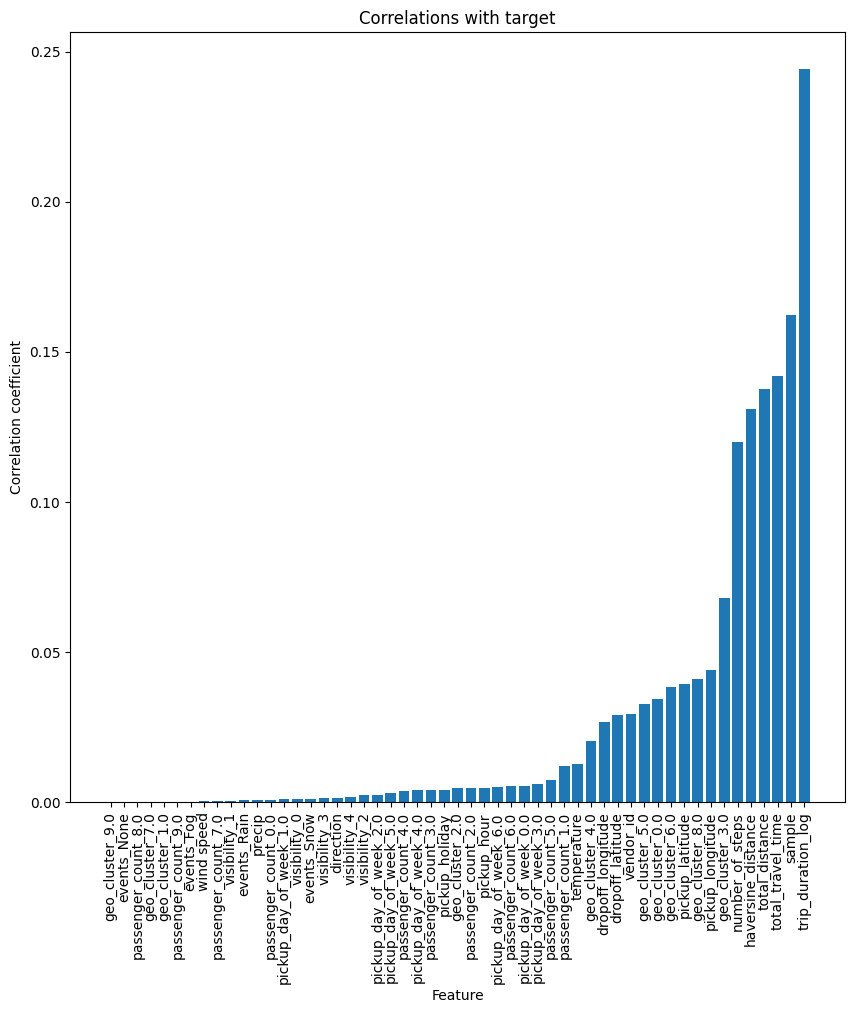

In [61]:
#Calculating the correlation module
corr_with_target = taxi_data_cleaned.corr()['trip_duration'].abs().sort_values()
#Removing the correlation of the target variable with itself
corr_with_target = corr_with_target.drop('trip_duration')
#Building a bar chart of correlations
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(corr_with_target.index, corr_with_target.values)
ax.set_title('Correlations with target') 
ax.set_xlabel('Feature')
ax.set_ylabel('Сorrelation coefficient');
ax.xaxis.set_tick_params(rotation=90)

### Calculating correlation pairs

In [62]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

corr_pairs = get_top_abs_correlations(taxi_data_cleaned, 20)
corr_pairs

sample               trip_duration_log      0.975906
total_distance       total_travel_time      0.957698
                     haversine_distance     0.951253
total_travel_time    haversine_distance     0.912474
events_None          events_Rain            0.896843
total_travel_time    number_of_steps        0.832419
total_distance       number_of_steps        0.795916
number_of_steps      haversine_distance     0.724565
passenger_count_1.0  passenger_count_2.0    0.639948
pickup_longitude     dropoff_longitude      0.633749
visibility_2         visibility_3           0.630054
dropoff_longitude    geo_cluster_1.0        0.623697
pickup_longitude     geo_cluster_1.0        0.614752
total_distance       geo_cluster_3.0        0.554301
haversine_distance   geo_cluster_3.0        0.531179
dropoff_latitude     geo_cluster_2.0        0.511421
                     geo_cluster_5.0        0.509552
pickup_longitude     geo_cluster_3.0        0.500467
pickup_latitude      geo_cluster_3.0        0.

In [63]:
taxi_data_cleaned = taxi_data_cleaned.drop(['total_travel_time', 'trip_duration'], axis=1)

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [64]:
taxi_data_cleaned = taxi_data_cleaned.query('sample == 1').drop(['sample'], axis=1)

In [65]:
X = taxi_data_cleaned.drop('trip_duration_log', axis=1)
# y = train_data['trip_duration']
y_log = taxi_data_cleaned['trip_duration_log']

In [66]:
new_taxi_test = new_taxi_test.drop('trip_duration', axis=1)

In [67]:
new_taxi_test = new_taxi_test.drop(['total_travel_time', 'trip_duration_log'], axis=1)

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [68]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


In [69]:
X_train.shape

(976975, 50)

In [70]:
new_taxi_test.shape

(625134, 50)

### Задание 4.4.
С помощью SelectKBest отберем 30 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

In [71]:
# # ваш код здесь
# selector = feature_selection.SelectKBest(feature_selection.f_regression, k=30)
# selector.fit(X_train, y_train_log)
 
# feature_lst = selector.get_feature_names_out()
# print(feature_lst)
# X_train = X_train[feature_lst]
# X_valid = X_valid[feature_lst]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью RobustScaler() из библиотеки sklearn. 

In [72]:
# ваш код здесь
scaler = preprocessing.RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [73]:
# new_taxi_test = new_taxi_test[feature_lst]

In [74]:
test_data_scaled = scaler.fit_transform(new_taxi_test)

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


In [75]:
test_id = taxi_test['id']

In [76]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log)
dtest = xgb.DMatrix(test_data_scaled)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [77]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror',
            'tree_method': 'gpu_hist'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.74060	valid-rmse:0.74004
[10]	train-rmse:0.49170	valid-rmse:0.49073
[20]	train-rmse:0.43949	valid-rmse:0.43847
[30]	train-rmse:0.42296	valid-rmse:0.42200
[40]	train-rmse:0.41367	valid-rmse:0.41293
[50]	train-rmse:0.40782	valid-rmse:0.40742
[60]	train-rmse:0.40354	valid-rmse:0.40351
[70]	train-rmse:0.40034	valid-rmse:0.40067
[80]	train-rmse:0.39838	valid-rmse:0.39900
[90]	train-rmse:0.39627	valid-rmse:0.39717
[100]	train-rmse:0.39460	valid-rmse:0.39581
[110]	train-rmse:0.39283	valid-rmse:0.39427
[120]	train-rmse:0.39152	valid-rmse:0.39326
[130]	train-rmse:0.39033	valid-rmse:0.39239
[140]	train-rmse:0.38911	valid-rmse:0.39155
[150]	train-rmse:0.38803	valid-rmse:0.39075
[160]	train-rmse:0.38715	valid-rmse:0.39014
[170]	train-rmse:0.38618	valid-rmse:0.38951
[180]	train-rmse:0.38505	valid-rmse:0.38870
[190]	train-rmse:0.38438	valid-rmse:0.38831
[200]	train-rmse:0.38372	valid-rmse:0.38786
[210]	train-rmse:0.38299	valid-rmse:0.38740
[220]	train-rmse:0.38229	valid-rmse:0.38694

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [78]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.expm1(model_xgb.predict(dtest))
print('Modeling RMSLE %.5f' % model_xgb.best_score)

Modeling RMSLE 0.38444


In [79]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submis_xgb_rob_all.csv', index=False)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

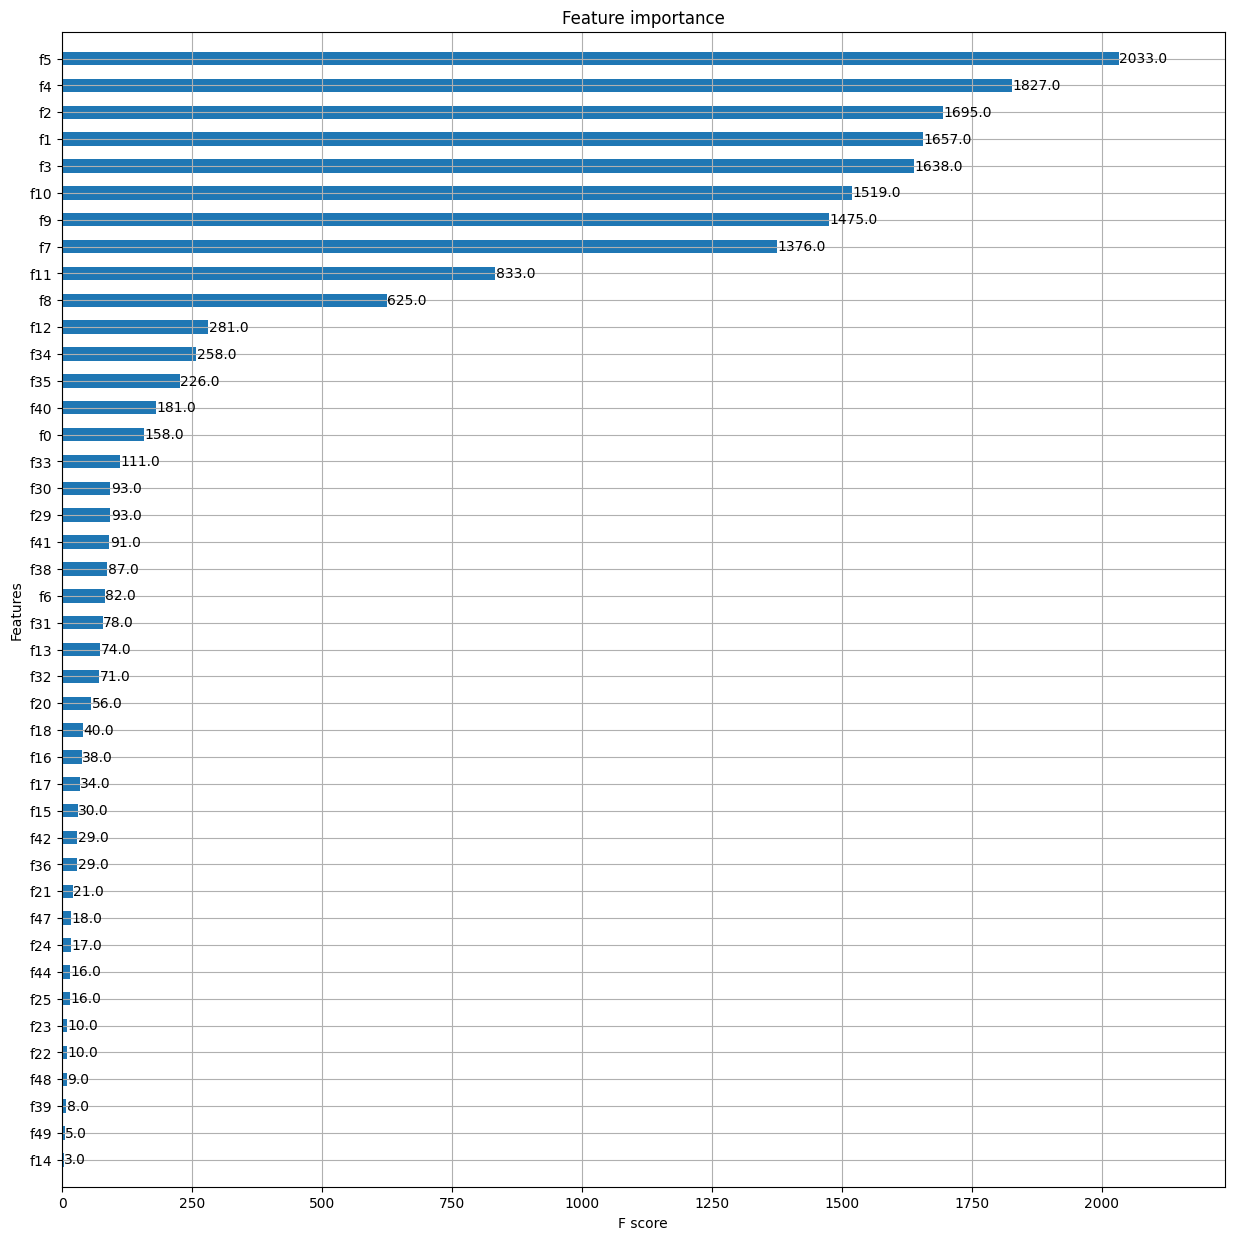

In [80]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model_xgb, ax = ax, height=0.5)

In [81]:
# Функция для оптимизации гиперпараметров
def objective(trial):
    # Подбор гиперпараметров
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.01)
    depth = trial.suggest_int('depth', 3, 10)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10)
    iterations = trial.suggest_int('iterations', 100, 600) 

    # Инициализация модели с выбранными гиперпараметрами
    model_cat = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        # bagging_temperature=0.2,
        # early_stopping_rounds=50,
        task_type='GPU',
        verbose=0  # Отключаем вывод информации
    )

    # Обучение модели
    model_cat.fit(X_train_scaled, y_train_log)

    # Прогнозирование и оценка качества
    predictions = model_cat.predict(X_valid_scaled)
    mse = metrics.mean_squared_error(y_valid_log, predictions)
    rmsle_valid = np.sqrt(mse)

    return rmsle_valid

# Создание и запуск исследования Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50) 

# Вывод лучших гиперпараметров
print("Best hyperparameters: ", study.best_params)
print("Best rmsle: ", study.best_value)

# Обучение финальной модели с лучшими гиперпараметрами
best_params = study.best_params
final_model_cat = CatBoostRegressor(
    iterations=best_params['iterations'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    # bagging_temperature=0.2,
    # early_stopping_rounds=50,
    task_type='GPU',
    verbose=100
)

# Обучение финальной модели на всех обучающих данных
final_model_cat.fit(X_train_scaled, y_train_log)

pred_cat = final_model_cat.predict(test_data_scaled)
pred_cat = np.expm1(pred_cat)

[I 2024-12-26 15:51:10,740] A new study created in memory with name: no-name-9438611e-fd74-48aa-8e02-5d3e030b96a5
[I 2024-12-26 15:51:13,327] Trial 0 finished with value: 0.4333208410859223 and parameters: {'learning_rate': 0.033772274703734485, 'depth': 5, 'l2_leaf_reg': 0.048754205619795446, 'iterations': 153}. Best is trial 0 with value: 0.4333208410859223.
[I 2024-12-26 15:51:16,351] Trial 1 finished with value: 0.389553171936757 and parameters: {'learning_rate': 0.37950926482313063, 'depth': 8, 'l2_leaf_reg': 0.0023899716347054348, 'iterations': 169}. Best is trial 1 with value: 0.389553171936757.
[I 2024-12-26 15:51:18,818] Trial 2 finished with value: 0.3955199684788008 and parameters: {'learning_rate': 0.3615163784968151, 'depth': 4, 'l2_leaf_reg': 0.00941842905451659, 'iterations': 229}. Best is trial 1 with value: 0.389553171936757.
[I 2024-12-26 15:51:20,766] Trial 3 finished with value: 0.45996418313840454 and parameters: {'learning_rate': 0.023223189308463156, 'depth': 3, 

Best hyperparameters:  {'learning_rate': 0.1816812875628637, 'depth': 10, 'l2_leaf_reg': 3.370823051027398, 'iterations': 555}
Best rmsle:  0.38204532512276584
0:	learn: 0.7031615	total: 16.8ms	remaining: 9.3s
100:	learn: 0.3843235	total: 1.47s	remaining: 6.58s
200:	learn: 0.3706655	total: 2.91s	remaining: 5.13s
300:	learn: 0.3616216	total: 4.37s	remaining: 3.69s
400:	learn: 0.3545972	total: 5.83s	remaining: 2.24s
500:	learn: 0.3486901	total: 7.28s	remaining: 785ms
554:	learn: 0.3458688	total: 8.08s	remaining: 0us


In [82]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': pred_cat})
submission.to_csv('submis_cat_rob_all.csv', index=False)

In [83]:
def objective(trial):
    # Определение гиперпараметров
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'device': 'gpu',
        'verbosity': 0,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
    }

    # Обучение модели
    model_lgb = lgb.LGBMRegressor(**param)
    model_lgb.fit(X_train_scaled, y_train_log)

    # Предсказание и оценка качества
    preds = model_lgb.predict(X_valid_scaled)
    mse = metrics.mean_squared_error(y_valid_log, preds)
    rmsle_valid = np.sqrt(mse)
    return rmsle_valid

# Оптимизация гиперпараметров
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Вывод лучших гиперпараметров
print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

# Обучение финальной модели с лучшими гиперпараметрами
final_model_lgb = lgb.LGBMRegressor(**best_params)
final_model_lgb.fit(X_train_scaled, y_train_log)

# Оценка финальной модели на тестовой выборке
final_preds = final_model_lgb.predict(test_data_scaled)
final_preds = np.expm1(final_preds)

[I 2024-12-26 15:57:07,150] A new study created in memory with name: no-name-2859cbec-5aea-40be-a450-f5e421ba91d3


[LightGBM] [Warning] feature_fraction is set=0.8694142905654112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8694142905654112
[LightGBM] [Warning] bagging_fraction is set=0.8997243369024978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8997243369024978
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8694142905654112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8694142905654112
[LightGBM] [Warning] bagging_fraction is set=0.8997243369024978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8997243369024978
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Warning] feature_fraction is set=0.8694142905654112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8694142905654112
[LightGBM] [Warning] bagging_fraction is set=0.8997243369024978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8997243369024978
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2024-12-26 15:57:25,238] Trial 0 finished with value: 0.7211943893553181 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'learning_rate': 0.001443031321293563, 'feature_fraction': 0.8694142905654112, 'bagging_fraction': 0.8997243369024978, 'bagging_freq': 8, 'max_depth': 48}. Best is trial 0 with value: 0.7211943893553181.


[LightGBM] [Warning] feature_fraction is set=0.927139157513649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.927139157513649
[LightGBM] [Warning] bagging_fraction is set=0.996159813817032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996159813817032
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.927139157513649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.927139157513649
[LightGBM] [Warning] bagging_fraction is set=0.996159813817032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996159813817032
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.927139157513649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.927139157513649
[LightGBM] [Warning] bagging_fraction 

[I 2024-12-26 15:57:34,904] Trial 1 finished with value: 0.7309775947758288 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'learning_rate': 0.0012801295832236697, 'feature_fraction': 0.927139157513649, 'bagging_fraction': 0.996159813817032, 'bagging_freq': 7, 'max_depth': 39}. Best is trial 0 with value: 0.7211943893553181.


[LightGBM] [Warning] feature_fraction is set=0.9421217677214686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9421217677214686
[LightGBM] [Warning] bagging_fraction is set=0.7660937886263949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7660937886263949
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9421217677214686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9421217677214686
[LightGBM] [Warning] bagging_fraction is set=0.7660937886263949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7660937886263949
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-12-26 15:57:44,837] Trial 2 finished with value: 0.40003148568862745 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'learning_rate': 0.07588975509205331, 'feature_fraction': 0.9421217677214686, 'bagging_fraction': 0.7660937886263949, 'bagging_freq': 10, 'max_depth': 6}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.8274252221959189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8274252221959189
[LightGBM] [Warning] bagging_fraction is set=0.9270187529194827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9270187529194827
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8274252221959189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8274252221959189
[LightGBM] [Warning] bagging_fraction is set=0.9270187529194827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9270187529194827
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8274252221959189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8274252221959189
[LightGBM] [Warning] bagging

[I 2024-12-26 15:58:16,559] Trial 3 finished with value: 0.9897260727876847 and parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'learning_rate': 0.07471262123814336, 'feature_fraction': 0.8274252221959189, 'bagging_fraction': 0.9270187529194827, 'bagging_freq': 9, 'max_depth': 32}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.9439951126311383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9439951126311383
[LightGBM] [Warning] bagging_fraction is set=0.8806579532247196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8806579532247196
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9439951126311383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9439951126311383
[LightGBM] [Warning] bagging_fraction is set=0.8806579532247196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8806579532247196
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9439951126311383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9439951126311383
[LightGBM] [Warning] bagging

[I 2024-12-26 15:58:40,543] Trial 4 finished with value: 1.2904204575965361 and parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'learning_rate': 0.053104367956503626, 'feature_fraction': 0.9439951126311383, 'bagging_fraction': 0.8806579532247196, 'bagging_freq': 6, 'max_depth': 40}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.5082281650533845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082281650533845
[LightGBM] [Warning] bagging_fraction is set=0.6577324027777557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6577324027777557
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5082281650533845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082281650533845
[LightGBM] [Warning] bagging_fraction is set=0.6577324027777557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6577324027777557
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5082281650533845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082281650533845
[LightGBM] [Warning] bagging

[I 2024-12-26 15:59:10,196] Trial 5 finished with value: 2.8353727147662187 and parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'learning_rate': 0.0032029530186639833, 'feature_fraction': 0.5082281650533845, 'bagging_fraction': 0.6577324027777557, 'bagging_freq': 7, 'max_depth': 13}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.7712930779382345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7712930779382345
[LightGBM] [Warning] bagging_fraction is set=0.9706198251736472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706198251736472
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7712930779382345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7712930779382345
[LightGBM] [Warning] bagging_fraction is set=0.9706198251736472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706198251736472
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7712930779382345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7712930779382345
[LightGBM] [Warning] bag

[I 2024-12-26 15:59:25,402] Trial 6 finished with value: 0.4318184874675103 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'learning_rate': 0.018619813948165014, 'feature_fraction': 0.7712930779382345, 'bagging_fraction': 0.9706198251736472, 'bagging_freq': 10, 'max_depth': 37}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.5131451545383892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5131451545383892
[LightGBM] [Warning] bagging_fraction is set=0.8139723857830934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8139723857830934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5131451545383892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5131451545383892
[LightGBM] [Warning] bagging_fraction is set=0.8139723857830934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8139723857830934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5131451545383892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5131451545383892
[LightGBM] [Warning] bagging

[I 2024-12-26 15:59:51,972] Trial 7 finished with value: 1.8914567421811992 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'learning_rate': 0.02685099905626185, 'feature_fraction': 0.5131451545383892, 'bagging_fraction': 0.8139723857830934, 'bagging_freq': 4, 'max_depth': 29}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.6153036351913418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6153036351913418
[LightGBM] [Warning] bagging_fraction is set=0.734450995619272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.734450995619272
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6153036351913418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6153036351913418
[LightGBM] [Warning] bagging_fraction is set=0.734450995619272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.734450995619272
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6153036351913418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6153036351913418
[LightGBM] [Warning] bagging_fra

[I 2024-12-26 16:00:12,451] Trial 8 finished with value: 0.9181397715764844 and parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'learning_rate': 0.08258384337392374, 'feature_fraction': 0.6153036351913418, 'bagging_fraction': 0.734450995619272, 'bagging_freq': 9, 'max_depth': 34}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.8019463883849939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8019463883849939
[LightGBM] [Warning] bagging_fraction is set=0.5022823896079818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5022823896079818
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8019463883849939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8019463883849939
[LightGBM] [Warning] bagging_fraction is set=0.5022823896079818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5022823896079818
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8019463883849939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8019463883849939
[LightGBM] [Warning] bag

[I 2024-12-26 16:00:22,618] Trial 9 finished with value: 0.6156315781183048 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'learning_rate': 0.004419182735478975, 'feature_fraction': 0.8019463883849939, 'bagging_fraction': 0.5022823896079818, 'bagging_freq': 10, 'max_depth': 41}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.9979967551968447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9979967551968447
[LightGBM] [Warning] bagging_fraction is set=0.6298135274740443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6298135274740443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9979967551968447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9979967551968447
[LightGBM] [Warning] bagging_fraction is set=0.6298135274740443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6298135274740443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9979967551968447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9979967551968447
[LightGBM] [Warning] bagging

[I 2024-12-26 16:00:26,361] Trial 10 finished with value: 0.5918334402305773 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'learning_rate': 0.012192447951986794, 'feature_fraction': 0.9979967551968447, 'bagging_fraction': 0.6298135274740443, 'bagging_freq': 1, 'max_depth': 1}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.7109555931860503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7109555931860503
[LightGBM] [Warning] bagging_fraction is set=0.7858209663021598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7858209663021598
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7109555931860503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7109555931860503
[LightGBM] [Warning] bagging_fraction is set=0.7858209663021598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7858209663021598
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7109555931860503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7109555931860503
[LightGBM] [Warning] bag

[I 2024-12-26 16:00:41,112] Trial 11 finished with value: 0.4199560570830117 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'learning_rate': 0.02256421025878102, 'feature_fraction': 0.7109555931860503, 'bagging_fraction': 0.7858209663021598, 'bagging_freq': 10, 'max_depth': 16}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.6712272717076853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6712272717076853
[LightGBM] [Warning] bagging_fraction is set=0.7523596440621234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523596440621234
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6712272717076853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6712272717076853
[LightGBM] [Warning] bagging_fraction is set=0.7523596440621234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523596440621234
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6712272717076853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6712272717076853
[LightGBM] [Warning] bagging

[I 2024-12-26 16:00:55,270] Trial 12 finished with value: 0.4062255982497455 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'learning_rate': 0.03306098457117649, 'feature_fraction': 0.6712272717076853, 'bagging_fraction': 0.7523596440621234, 'bagging_freq': 4, 'max_depth': 17}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.6809131500648637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6809131500648637
[LightGBM] [Warning] bagging_fraction is set=0.6892257378598861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6892257378598861
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6809131500648637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6809131500648637
[LightGBM] [Warning] bagging_fraction is set=0.6892257378598861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6892257378598861
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6809131500648637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6809131500648637
[LightGBM] [Warning] bagging

[I 2024-12-26 16:01:09,498] Trial 13 finished with value: 0.4005742352405558 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'learning_rate': 0.040190266353804995, 'feature_fraction': 0.6809131500648637, 'bagging_fraction': 0.6892257378598861, 'bagging_freq': 4, 'max_depth': 0}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.6308904504363398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6308904504363398
[LightGBM] [Warning] bagging_fraction is set=0.6772975653673005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6772975653673005
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6308904504363398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6308904504363398
[LightGBM] [Warning] bagging_fraction is set=0.6772975653673005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6772975653673005
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6308904504363398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6308904504363398
[LightGBM] [Warning] bagging

[I 2024-12-26 16:01:14,681] Trial 14 finished with value: 0.497179854782699 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'learning_rate': 0.04383259112896791, 'feature_fraction': 0.6308904504363398, 'bagging_fraction': 0.6772975653673005, 'bagging_freq': 3, 'max_depth': 1}. Best is trial 2 with value: 0.40003148568862745.


[LightGBM] [Warning] feature_fraction is set=0.716888321255959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.716888321255959
[LightGBM] [Warning] bagging_fraction is set=0.5715307627425494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5715307627425494
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.716888321255959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.716888321255959
[LightGBM] [Warning] bagging_fraction is set=0.5715307627425494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5715307627425494
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.716888321255959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.716888321255959
[LightGBM] [Warning] bagging_fract

[I 2024-12-26 16:01:28,222] Trial 15 finished with value: 0.38863697649201145 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'learning_rate': 0.09638344777435055, 'feature_fraction': 0.716888321255959, 'bagging_fraction': 0.5715307627425494, 'bagging_freq': 2, 'max_depth': 8}. Best is trial 15 with value: 0.38863697649201145.


[LightGBM] [Warning] feature_fraction is set=0.8797884688458281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8797884688458281
[LightGBM] [Warning] bagging_fraction is set=0.559586975588316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.559586975588316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8797884688458281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8797884688458281
[LightGBM] [Warning] bagging_fraction is set=0.559586975588316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.559586975588316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8797884688458281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8797884688458281
[LightGBM] [Warning] bagging_fra

[I 2024-12-26 16:01:39,044] Trial 16 finished with value: 0.38712293532813163 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'learning_rate': 0.09751017280154037, 'feature_fraction': 0.8797884688458281, 'bagging_fraction': 0.559586975588316, 'bagging_freq': 1, 'max_depth': 9}. Best is trial 16 with value: 0.38712293532813163.


[LightGBM] [Warning] feature_fraction is set=0.8592905052801927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8592905052801927
[LightGBM] [Warning] bagging_fraction is set=0.5483334721823634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5483334721823634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8592905052801927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8592905052801927
[LightGBM] [Warning] bagging_fraction is set=0.5483334721823634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5483334721823634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8592905052801927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8592905052801927
[LightGBM] [Warning] bagging

[I 2024-12-26 16:01:49,897] Trial 17 finished with value: 0.5435905133907013 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'learning_rate': 0.007104385286531328, 'feature_fraction': 0.8592905052801927, 'bagging_fraction': 0.5483334721823634, 'bagging_freq': 1, 'max_depth': 11}. Best is trial 16 with value: 0.38712293532813163.


[LightGBM] [Warning] feature_fraction is set=0.7422676660509885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422676660509885
[LightGBM] [Warning] bagging_fraction is set=0.5893011782653912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893011782653912
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7422676660509885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422676660509885
[LightGBM] [Warning] bagging_fraction is set=0.5893011782653912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893011782653912
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7422676660509885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422676660509885
[LightGBM] [Warning] bagging

[I 2024-12-26 16:02:04,910] Trial 18 finished with value: 0.46912169873192133 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'learning_rate': 0.012503715724952177, 'feature_fraction': 0.7422676660509885, 'bagging_fraction': 0.5893011782653912, 'bagging_freq': 2, 'max_depth': 23}. Best is trial 16 with value: 0.38712293532813163.


[LightGBM] [Warning] feature_fraction is set=0.5955953453609591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5955953453609591
[LightGBM] [Warning] bagging_fraction is set=0.5601921644797319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5601921644797319
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5955953453609591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5955953453609591
[LightGBM] [Warning] bagging_fraction is set=0.5601921644797319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5601921644797319
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5955953453609591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5955953453609591
[LightGBM] [Warning] bagging

[I 2024-12-26 16:02:18,523] Trial 19 finished with value: 0.3885340983400241 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'learning_rate': 0.09936513583151269, 'feature_fraction': 0.5955953453609591, 'bagging_fraction': 0.5601921644797319, 'bagging_freq': 2, 'max_depth': 21}. Best is trial 16 with value: 0.38712293532813163.


[LightGBM] [Warning] feature_fraction is set=0.5713334472965497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5713334472965497
[LightGBM] [Warning] bagging_fraction is set=0.5058534509379738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5058534509379738
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5713334472965497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5713334472965497
[LightGBM] [Warning] bagging_fraction is set=0.5058534509379738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5058534509379738
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5713334472965497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5713334472965497
[LightGBM] [Warning] bagging

[I 2024-12-26 16:02:31,773] Trial 20 finished with value: 0.39740018286036666 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'learning_rate': 0.05215848657584333, 'feature_fraction': 0.5713334472965497, 'bagging_fraction': 0.5058534509379738, 'bagging_freq': 2, 'max_depth': 22}. Best is trial 16 with value: 0.38712293532813163.


[LightGBM] [Warning] feature_fraction is set=0.5817820092409353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5817820092409353
[LightGBM] [Warning] bagging_fraction is set=0.5779513304658567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5779513304658567
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5817820092409353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5817820092409353
[LightGBM] [Warning] bagging_fraction is set=0.5779513304658567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5779513304658567
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5817820092409353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5817820092409353
[LightGBM] [Warning] bagging

[I 2024-12-26 16:02:45,103] Trial 21 finished with value: 0.39526288971513596 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'learning_rate': 0.07682473308955914, 'feature_fraction': 0.5817820092409353, 'bagging_fraction': 0.5779513304658567, 'bagging_freq': 2, 'max_depth': 7}. Best is trial 16 with value: 0.38712293532813163.


[LightGBM] [Warning] feature_fraction is set=0.7470028104065948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7470028104065948
[LightGBM] [Warning] bagging_fraction is set=0.6101304591150012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6101304591150012
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7470028104065948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7470028104065948
[LightGBM] [Warning] bagging_fraction is set=0.6101304591150012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6101304591150012
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7470028104065948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7470028104065948
[LightGBM] [Warning] bagging

[I 2024-12-26 16:02:56,693] Trial 22 finished with value: 0.4008439810717342 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'learning_rate': 0.058236601432011544, 'feature_fraction': 0.7470028104065948, 'bagging_fraction': 0.6101304591150012, 'bagging_freq': 3, 'max_depth': 7}. Best is trial 16 with value: 0.38712293532813163.


[LightGBM] [Warning] feature_fraction is set=0.6487271121782849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6487271121782849
[LightGBM] [Warning] bagging_fraction is set=0.5506433347064282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5506433347064282
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6487271121782849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6487271121782849
[LightGBM] [Warning] bagging_fraction is set=0.5506433347064282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5506433347064282
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6487271121782849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6487271121782849
[LightGBM] [Warning] bagging

[I 2024-12-26 16:03:07,664] Trial 23 finished with value: 0.3868951311626429 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'learning_rate': 0.09071877403967642, 'feature_fraction': 0.6487271121782849, 'bagging_fraction': 0.5506433347064282, 'bagging_freq': 1, 'max_depth': 20}. Best is trial 23 with value: 0.3868951311626429.


[LightGBM] [Warning] feature_fraction is set=0.5675808816721035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5675808816721035
[LightGBM] [Warning] bagging_fraction is set=0.5393713579293559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393713579293559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5675808816721035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5675808816721035
[LightGBM] [Warning] bagging_fraction is set=0.5393713579293559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393713579293559
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5675808816721035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5675808816721035
[LightGBM] [Warning] bagging

[I 2024-12-26 16:03:19,451] Trial 24 finished with value: 0.4060736549003593 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'learning_rate': 0.034275015421057, 'feature_fraction': 0.5675808816721035, 'bagging_fraction': 0.5393713579293559, 'bagging_freq': 1, 'max_depth': 20}. Best is trial 23 with value: 0.3868951311626429.


[LightGBM] [Warning] feature_fraction is set=0.6215401667765795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6215401667765795
[LightGBM] [Warning] bagging_fraction is set=0.6320649520229825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6320649520229825
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6215401667765795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6215401667765795
[LightGBM] [Warning] bagging_fraction is set=0.6320649520229825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6320649520229825
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6215401667765795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6215401667765795
[LightGBM] [Warning] bagging

[I 2024-12-26 16:03:33,527] Trial 25 finished with value: 0.3856662856545519 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'learning_rate': 0.09996646278156258, 'feature_fraction': 0.6215401667765795, 'bagging_fraction': 0.6320649520229825, 'bagging_freq': 3, 'max_depth': 28}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.6468026639606602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6468026639606602
[LightGBM] [Warning] bagging_fraction is set=0.6325316895691964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6325316895691964
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6468026639606602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6468026639606602
[LightGBM] [Warning] bagging_fraction is set=0.6325316895691964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6325316895691964
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6468026639606602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6468026639606602
[LightGBM] [Warning] bagging

[I 2024-12-26 16:03:48,746] Trial 26 finished with value: 0.43795247002190507 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'learning_rate': 0.01766771088472491, 'feature_fraction': 0.6468026639606602, 'bagging_fraction': 0.6325316895691964, 'bagging_freq': 3, 'max_depth': 28}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.6759190095415519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6759190095415519
[LightGBM] [Warning] bagging_fraction is set=0.5314214840502575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5314214840502575
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6759190095415519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6759190095415519
[LightGBM] [Warning] bagging_fraction is set=0.5314214840502575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5314214840502575
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6759190095415519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6759190095415519
[LightGBM] [Warning] bagging

[I 2024-12-26 16:04:21,331] Trial 27 finished with value: 1.1756173675135255 and parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'learning_rate': 0.06002939519950986, 'feature_fraction': 0.6759190095415519, 'bagging_fraction': 0.5314214840502575, 'bagging_freq': 5, 'max_depth': 27}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.5482454526029695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5482454526029695
[LightGBM] [Warning] bagging_fraction is set=0.7051844332110453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7051844332110453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5482454526029695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5482454526029695
[LightGBM] [Warning] bagging_fraction is set=0.7051844332110453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7051844332110453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5482454526029695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5482454526029695
[LightGBM] [Warning] bagging

[I 2024-12-26 16:04:33,099] Trial 28 finished with value: 0.5364817401792241 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'learning_rate': 0.008152555470665875, 'feature_fraction': 0.5482454526029695, 'bagging_fraction': 0.7051844332110453, 'bagging_freq': 1, 'max_depth': 17}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.8910541996110016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8910541996110016
[LightGBM] [Warning] bagging_fraction is set=0.6136852917365849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6136852917365849
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8910541996110016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8910541996110016
[LightGBM] [Warning] bagging_fraction is set=0.6136852917365849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6136852917365849
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8910541996110016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8910541996110016
[LightGBM] [Warning] bagging

[I 2024-12-26 16:04:47,011] Trial 29 finished with value: 0.6499217510374297 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'learning_rate': 0.003201833948717567, 'feature_fraction': 0.8910541996110016, 'bagging_fraction': 0.6136852917365849, 'bagging_freq': 3, 'max_depth': 47}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.7816683982299636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816683982299636
[LightGBM] [Warning] bagging_fraction is set=0.654564701844572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.654564701844572
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7816683982299636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816683982299636
[LightGBM] [Warning] bagging_fraction is set=0.654564701844572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.654564701844572
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7816683982299636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816683982299636
[LightGBM] [Warning] bagging_fra

[I 2024-12-26 16:05:00,079] Trial 30 finished with value: 0.6950264367535831 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'learning_rate': 0.0020846412724878074, 'feature_fraction': 0.7816683982299636, 'bagging_fraction': 0.654564701844572, 'bagging_freq': 5, 'max_depth': 14}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.6043578900810692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043578900810692
[LightGBM] [Warning] bagging_fraction is set=0.5694164787278619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5694164787278619
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6043578900810692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043578900810692
[LightGBM] [Warning] bagging_fraction is set=0.5694164787278619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5694164787278619
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6043578900810692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6043578900810692
[LightGBM] [Warning] bagging

[I 2024-12-26 16:05:13,374] Trial 31 finished with value: 0.3897358403623117 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'learning_rate': 0.08749529368092307, 'feature_fraction': 0.6043578900810692, 'bagging_fraction': 0.5694164787278619, 'bagging_freq': 2, 'max_depth': 26}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.6474841412938332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6474841412938332
[LightGBM] [Warning] bagging_fraction is set=0.5342930242352958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5342930242352958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6474841412938332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6474841412938332
[LightGBM] [Warning] bagging_fraction is set=0.5342930242352958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5342930242352958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6474841412938332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6474841412938332
[LightGBM] [Warning] bagging

[I 2024-12-26 16:05:24,601] Trial 32 finished with value: 0.38652922888594765 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'learning_rate': 0.09773806532935664, 'feature_fraction': 0.6474841412938332, 'bagging_fraction': 0.5342930242352958, 'bagging_freq': 1, 'max_depth': 20}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.6517133681762497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517133681762497
[LightGBM] [Warning] bagging_fraction is set=0.5198383125754997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5198383125754997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6517133681762497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517133681762497
[LightGBM] [Warning] bagging_fraction is set=0.5198383125754997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5198383125754997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6517133681762497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517133681762497
[LightGBM] [Warning] bagging

[I 2024-12-26 16:05:35,658] Trial 33 finished with value: 0.3915666479566153 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'learning_rate': 0.06402641664800365, 'feature_fraction': 0.6517133681762497, 'bagging_fraction': 0.5198383125754997, 'bagging_freq': 1, 'max_depth': 19}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.7104812856226557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7104812856226557
[LightGBM] [Warning] bagging_fraction is set=0.5925427246716991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5925427246716991
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7104812856226557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7104812856226557
[LightGBM] [Warning] bagging_fraction is set=0.5925427246716991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5925427246716991
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7104812856226557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7104812856226557
[LightGBM] [Warning] bagging

[I 2024-12-26 16:05:46,469] Trial 34 finished with value: 0.3972006529176114 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'learning_rate': 0.04724830806797978, 'feature_fraction': 0.7104812856226557, 'bagging_fraction': 0.5925427246716991, 'bagging_freq': 1, 'max_depth': 24}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.5421241204107965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421241204107965
[LightGBM] [Warning] bagging_fraction is set=0.54086666983243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.54086666983243
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5421241204107965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421241204107965
[LightGBM] [Warning] bagging_fraction is set=0.54086666983243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.54086666983243
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5421241204107965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5421241204107965
[LightGBM] [Warning] bagging_fractio

[I 2024-12-26 16:06:00,281] Trial 35 finished with value: 0.3870603956781317 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'learning_rate': 0.09779709120883098, 'feature_fraction': 0.5421241204107965, 'bagging_fraction': 0.54086666983243, 'bagging_freq': 3, 'max_depth': 32}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.5396891987602258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5396891987602258
[LightGBM] [Warning] bagging_fraction is set=0.530565218739465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.530565218739465
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5396891987602258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5396891987602258
[LightGBM] [Warning] bagging_fraction is set=0.530565218739465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.530565218739465
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5396891987602258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5396891987602258
[LightGBM] [Warning] bagging_fra

[I 2024-12-26 16:06:33,745] Trial 36 finished with value: 2.9525850539316902 and parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'learning_rate': 0.0010190429519348837, 'feature_fraction': 0.5396891987602258, 'bagging_fraction': 0.530565218739465, 'bagging_freq': 6, 'max_depth': 31}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.5460444763945327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5460444763945327
[LightGBM] [Warning] bagging_fraction is set=0.6087139185897028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6087139185897028
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5460444763945327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5460444763945327
[LightGBM] [Warning] bagging_fraction is set=0.6087139185897028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6087139185897028
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5460444763945327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5460444763945327
[LightGBM] [Warning] bagging

[I 2024-12-26 16:06:47,436] Trial 37 finished with value: 0.3906234704760919 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'learning_rate': 0.06926836340886443, 'feature_fraction': 0.5460444763945327, 'bagging_fraction': 0.6087139185897028, 'bagging_freq': 4, 'max_depth': 36}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.6238170126710118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238170126710118
[LightGBM] [Warning] bagging_fraction is set=0.873728093565787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.873728093565787
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6238170126710118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238170126710118
[LightGBM] [Warning] bagging_fraction is set=0.873728093565787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.873728093565787
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6238170126710118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238170126710118
[LightGBM] [Warning] bagging_fra

[I 2024-12-26 16:07:24,657] Trial 38 finished with value: 1.6873060294098017 and parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'learning_rate': 0.03404393376322778, 'feature_fraction': 0.6238170126710118, 'bagging_fraction': 0.873728093565787, 'bagging_freq': 3, 'max_depth': 32}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.5051829449208677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051829449208677
[LightGBM] [Warning] bagging_fraction is set=0.6488946721822418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6488946721822418
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5051829449208677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051829449208677
[LightGBM] [Warning] bagging_fraction is set=0.6488946721822418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6488946721822418
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5051829449208677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051829449208677
[LightGBM] [Warning] bagging

[I 2024-12-26 16:07:39,043] Trial 39 finished with value: 0.3897403633923451 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'learning_rate': 0.07291311014977983, 'feature_fraction': 0.5051829449208677, 'bagging_fraction': 0.6488946721822418, 'bagging_freq': 5, 'max_depth': 43}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.6549925702043512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6549925702043512
[LightGBM] [Warning] bagging_fraction is set=0.5207767356376692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5207767356376692
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6549925702043512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6549925702043512
[LightGBM] [Warning] bagging_fraction is set=0.5207767356376692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5207767356376692
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6549925702043512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6549925702043512
[LightGBM] [Warning] bagging

[I 2024-12-26 16:08:11,914] Trial 40 finished with value: 1.3672298716470683 and parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'learning_rate': 0.04854371746406878, 'feature_fraction': 0.6549925702043512, 'bagging_fraction': 0.5207767356376692, 'bagging_freq': 7, 'max_depth': 30}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.8927144612688115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8927144612688115
[LightGBM] [Warning] bagging_fraction is set=0.5529401418005258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5529401418005258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8927144612688115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8927144612688115
[LightGBM] [Warning] bagging_fraction is set=0.5529401418005258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5529401418005258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8927144612688115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8927144612688115
[LightGBM] [Warning] bagging

[I 2024-12-26 16:08:22,288] Trial 41 finished with value: 0.3871786699419853 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'learning_rate': 0.09992011496422498, 'feature_fraction': 0.8927144612688115, 'bagging_fraction': 0.5529401418005258, 'bagging_freq': 1, 'max_depth': 25}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.8404046497847738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404046497847738
[LightGBM] [Warning] bagging_fraction is set=0.5888408651528243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5888408651528243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8404046497847738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404046497847738
[LightGBM] [Warning] bagging_fraction is set=0.5888408651528243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5888408651528243
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8404046497847738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404046497847738
[LightGBM] [Warning] bagging

[I 2024-12-26 16:08:37,016] Trial 42 finished with value: 0.3876362869844204 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'learning_rate': 0.07870860095278998, 'feature_fraction': 0.8404046497847738, 'bagging_fraction': 0.5888408651528243, 'bagging_freq': 2, 'max_depth': 34}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.9736150364883035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9736150364883035
[LightGBM] [Warning] bagging_fraction is set=0.5054435532952561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5054435532952561
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9736150364883035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9736150364883035
[LightGBM] [Warning] bagging_fraction is set=0.5054435532952561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5054435532952561
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9736150364883035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9736150364883035
[LightGBM] [Warning] bagging

[I 2024-12-26 16:08:47,721] Trial 43 finished with value: 0.39160746117750245 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'learning_rate': 0.06395539587407519, 'feature_fraction': 0.9736150364883035, 'bagging_fraction': 0.5054435532952561, 'bagging_freq': 1, 'max_depth': 11}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.6982017981949521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6982017981949521
[LightGBM] [Warning] bagging_fraction is set=0.5482706906144469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5482706906144469
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6982017981949521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6982017981949521
[LightGBM] [Warning] bagging_fraction is set=0.5482706906144469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5482706906144469
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6982017981949521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6982017981949521
[LightGBM] [Warning] bagging

[I 2024-12-26 16:09:00,540] Trial 44 finished with value: 0.3889969564236092 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'learning_rate': 0.08244055003824188, 'feature_fraction': 0.6982017981949521, 'bagging_fraction': 0.5482706906144469, 'bagging_freq': 3, 'max_depth': 14}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.8185671516193223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8185671516193223
[LightGBM] [Warning] bagging_fraction is set=0.6279654645520654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6279654645520654
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8185671516193223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8185671516193223
[LightGBM] [Warning] bagging_fraction is set=0.6279654645520654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6279654645520654
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8185671516193223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8185671516193223
[LightGBM] [Warning] bagging

[I 2024-12-26 16:09:09,812] Trial 45 finished with value: 0.44842747029498875 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'learning_rate': 0.02754567661955667, 'feature_fraction': 0.8185671516193223, 'bagging_fraction': 0.6279654645520654, 'bagging_freq': 2, 'max_depth': 4}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.6310971481592018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6310971481592018
[LightGBM] [Warning] bagging_fraction is set=0.5699135943465989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5699135943465989
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6310971481592018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6310971481592018
[LightGBM] [Warning] bagging_fraction is set=0.5699135943465989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5699135943465989
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6310971481592018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6310971481592018
[LightGBM] [Warning] bagging

[I 2024-12-26 16:09:21,588] Trial 46 finished with value: 0.3883105956302153 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'learning_rate': 0.09926067154495331, 'feature_fraction': 0.6310971481592018, 'bagging_fraction': 0.5699135943465989, 'bagging_freq': 4, 'max_depth': 38}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.5275489581046757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275489581046757
[LightGBM] [Warning] bagging_fraction is set=0.8486311173689551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486311173689551
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5275489581046757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275489581046757
[LightGBM] [Warning] bagging_fraction is set=0.8486311173689551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486311173689551
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5275489581046757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5275489581046757
[LightGBM] [Warning] bagging

[I 2024-12-26 16:09:31,675] Trial 47 finished with value: 0.4072294792760628 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'learning_rate': 0.04130477936877144, 'feature_fraction': 0.5275489581046757, 'bagging_fraction': 0.8486311173689551, 'bagging_freq': 1, 'max_depth': 19}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.5907080238037283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5907080238037283
[LightGBM] [Warning] bagging_fraction is set=0.6849280286357498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849280286357498
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5907080238037283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5907080238037283
[LightGBM] [Warning] bagging_fraction is set=0.6849280286357498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849280286357498
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5907080238037283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5907080238037283
[LightGBM] [Warning] bagging

[I 2024-12-26 16:09:43,170] Trial 48 finished with value: 0.40050392833712584 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'learning_rate': 0.05778200943670752, 'feature_fraction': 0.5907080238037283, 'bagging_fraction': 0.6849280286357498, 'bagging_freq': 9, 'max_depth': 34}. Best is trial 25 with value: 0.3856662856545519.


[LightGBM] [Warning] feature_fraction is set=0.7693592526677532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7693592526677532
[LightGBM] [Warning] bagging_fraction is set=0.6008429419432152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6008429419432152
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7693592526677532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7693592526677532
[LightGBM] [Warning] bagging_fraction is set=0.6008429419432152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6008429419432152
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7693592526677532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7693592526677532
[LightGBM] [Warning] bagging

[I 2024-12-26 16:10:17,722] Trial 49 finished with value: 0.9071826828387256 and parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'learning_rate': 0.08268934920488917, 'feature_fraction': 0.7693592526677532, 'bagging_fraction': 0.6008429419432152, 'bagging_freq': 2, 'max_depth': 11}. Best is trial 25 with value: 0.3856662856545519.


Best hyperparameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'learning_rate': 0.09996646278156258, 'feature_fraction': 0.6215401667765795, 'bagging_fraction': 0.6320649520229825, 'bagging_freq': 3, 'max_depth': 28}
Best RMSE: 0.3856662856545519
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 976975, number of used features: 42
[LightGBM] [Info] Start training from score 6.468338
[LightGBM] [Warning] Unknown parameter: l2_l

In [84]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': final_preds})
submission.to_csv('submis_lgb_rob_all.csv', index=False)